In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

%config InlineBackend.figure_format = 'svg'

In [2]:
DATA_DIR = '../../datasets/tokenized/'

df = pd.read_csv(f'{DATA_DIR}blog_authorship_tokenized.csv', usecols=['text', 'tokenized', 'age_group'])
df.sample(5)

,text,age_group,tokenized
97229,chomping a deer leg in dire need of a flea dip...,>35,chomping a deer leg in dire need of a flea dip...
163815,"progress & committment: called ralph, a local ...",25-34,"progress & committment : called ralph , a loca..."
618773,Huh? I didn't get a call about Baltymore. T__T...,<18,huh ? i did n't get a call about baltymore . t...
179248,Judge not lest ye be judged yourself... Went o...,18-24,judge not lest ye be judged yourself ... went ...
7928,i have eaten too much today. i am disgusted wi...,<18,i have eaten too much today . i am disgusted w...


In [3]:
df['age_group'].value_counts(dropna=False)

<18      218124
25-34    195382
18-24    142348
>35       79745
Name: age_group, dtype: int64

In [4]:
df_ = df.copy()

In [5]:
# Combine 18-24 and 25-34 into a single class
df_['age_group'] = df_['age_group'].apply(lambda x: '18-34' if x in {'18-24', '25-34'} else x)

In [6]:
df_ = df_.groupby('age_group').sample(25000, random_state=97)
df_.groupby('age_group').count()

,text,tokenized
age_group,,
18-34,25000,25000
<18,25000,25000
>35,25000,25000


In [7]:
enc = LabelEncoder()
enc.fit(df_['age_group'])
encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
df_['age_group'] = enc.transform(df_['age_group'])
encoded_labels

{'18-34': 0, '<18': 1, '>35': 2}

In [8]:
X = df_['text']
y = df_['age_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=97)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000,), (15000,), (60000,), (15000,))

In [9]:
vect = TfidfVectorizer()
svm = LinearSVC()

pipe = make_pipeline(vect, svm)

In [10]:
param_grid = {
    'tfidfvectorizer__ngram_range': [(1, 1)],
    'linearsvc__random_state': [97],
}

In [11]:
gs = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, refit=True, verbose=5)

gs.fit(X_train, y_train)
print(gs.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'linearsvc__random_state': 97, 'tfidfvectorizer__ngram_range': (1, 1)}


In [12]:
y_pred = gs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.51      0.53      4965
           1       0.74      0.75      0.75      5025
           2       0.62      0.65      0.64      5010

    accuracy                           0.64     15000
   macro avg       0.64      0.64      0.64     15000
weighted avg       0.64      0.64      0.64     15000



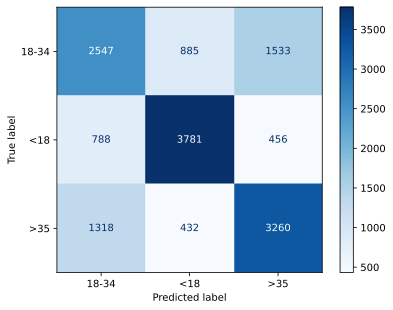

In [13]:
cm = confusion_matrix(y_test, y_pred, labels=gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
disp.display_labels = encoded_labels
disp.plot(cmap='Blues');

In [14]:
import joblib

joblib.dump(gs, 'age_baseline_3-class.joblib')

['age_baseline_3-class.joblib']

In [14]:
# model = joblib.load('age_baseline.joblib')

# def predict_age(text):
#     classes = encoded_labels
#     classes = {v: k for k, v in classes.items()} # reverse the dict
#     return classes[model.predict([text])[0]]

## Add *n*-gram features

In [15]:
from tempfile import mkdtemp
from shutil import rmtree

In [16]:
cache_dir = mkdtemp()

pipe = Pipeline(
    [
        ('vect', TfidfVectorizer()),
        ('clf', LinearSVC(random_state=97))
    ],
    memory=cache_dir
)

In [17]:
param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vect__analyzer': ['word', 'char'],
}

In [18]:
gs = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, refit=True, verbose=5)

gs.fit(X_train, y_train)
print(gs.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


c:\Users\dimboump\workspace\clips-internship\venv\lib\site-packages\sklearn\pipeline.py:336: UserWarning: Persisting input arguments took 16.82s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


{'vect__analyzer': 'word', 'vect__ngram_range': (1, 2)}


In [19]:
y_pred = gs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.50      0.53      4965
           1       0.76      0.77      0.76      5025
           2       0.63      0.68      0.65      5010

    accuracy                           0.65     15000
   macro avg       0.65      0.65      0.65     15000
weighted avg       0.65      0.65      0.65     15000



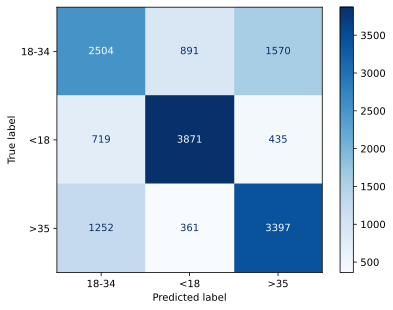

In [20]:
cm = confusion_matrix(y_test, y_pred, labels=gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
disp.display_labels = encoded_labels
disp.plot(cmap='Blues');

In [21]:
import joblib

joblib.dump(gs, 'age_ngram_3-class.joblib')

['age_ngram_3-class.joblib']

In [22]:
rmtree(cache_dir)

### Add PoS and punctuation features

In [27]:
DATA_DIR = '../../datasets/tokenized'

init_df = pd.read_csv(f'{DATA_DIR}/blog_authorship_tokenized_pos_punct_final.csv')
init_df.sample(5)

,text,gender,horoscope,job,age_group,tokenized,pos,total_punct,punct_dist,count_punct
104759,MAGNANIMITY This is Continuation of my earlier...,male,Virgo,Student,25-34,magnanimity this is continuation of my earlier...,PROPN DET AUX NOUN ADP PRON ADJ NOUN PUNCT PRO...,17,0.016983,"{'!': 0, '""': 0, '#': 0, '$': 0, '%': 0, '&': ..."
453046,"Well it does if this is posted Joker ===== ""Co...",male,Capricorn,Government,18-24,well it does if this is posted joker = = = = =...,INTJ PRON AUX SCONJ DET AUX VERB PROPN PROPN N...,50,0.173010,"{'!': 2, '""': 2, '#': 0, '$': 0, '%': 0, '&': ..."
632687,"Feeling pretty crappy, still... shouldn't a co...",male,Libra,Arts,18-24,"feeling pretty crappy , still ... should n't a...",VERB ADV ADJ PUNCT ADV PUNCT AUX PART DET ADJ ...,29,0.048414,"{'!': 1, '""': 2, '#': 0, '$': 0, '%': 0, '&': ..."
339210,sent via my phone while in a meeting Just a q...,male,Libra,Communications-Media,25-34,sent via my phone while in a meeting just a ...,SPACE VERB ADP PRON NOUN SCONJ ADP DET NOUN AD...,35,0.059625,"{'!': 4, '""': 4, '#': 0, '$': 0, '%': 0, '&': ..."
2998,i just found out that D is getting married in ...,female,Aquarius,indUnk,18-24,i just found out that d is getting married in ...,PRON ADV VERB ADP SCONJ PROPN AUX VERB VERB AD...,45,0.031337,"{'!': 0, '""': 0, '#': 0, '$': 0, '%': 0, '&': ..."


In [28]:
df_ = df.drop(['horoscope', 'job', 'gender', 'tokenized'], axis=1)
df_ = df_.groupby('age_group').sample(25000)
df_.sample(5)

,text,age_group,pos,total_punct,punct_dist,count_punct
1429,Good day turned bad turned good. Thats the way...,<18,ADJ NOUN VERB ADJ VERB ADJ PUNCT DET VERB DET ...,30,0.052632,"{'!': 0, '""': 2, '#': 0, '$': 0, '%': 0, '&': ..."
558720,You may think I'm a bit weird but I've never p...,25-34,PRON AUX VERB PRON AUX DET NOUN ADJ CCONJ PRON...,110,0.049909,"{'!': 0, '""': 0, '#': 0, '$': 2, '%': 0, '&': ..."
626294,My good friend Holly called me from Melbourne ...,18-24,PRON ADJ NOUN PROPN VERB PRON ADP PROPN ADJ NO...,40,0.027082,"{'!': 0, '""': 2, '#': 0, '$': 0, '%': 0, '&': ..."
562614,Recent Events Shit on my end has been kinda up...,>35,ADJ NOUN INTJ ADP PRON NOUN AUX AUX ADV ADV CC...,119,0.041034,"{'!': 7, '""': 2, '#': 0, '$': 0, '%': 0, '&': ..."
535375,According to a new study about the life of chu...,>35,VERB ADP DET ADJ NOUN ADP DET NOUN ADP NOUN AD...,44,0.045314,"{'!': 0, '""': 4, '#': 0, '$': 0, '%': 0, '&': ..."


In [29]:
df_['age_group'].value_counts(dropna=False)

18-24    25000
25-34    25000
<18      25000
>35      25000
Name: age_group, dtype: int64

In [30]:
enc = LabelEncoder()
enc.fit(df_['age_group'])
encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
df_['age_group'] = enc.transform(df_['age_group'])
encoded_labels

{'18-24': 0, '25-34': 1, '<18': 2, '>35': 3}

In [31]:
X = df_.drop('age_group', axis=1)
y = df_['age_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=97)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80000, 5), (20000, 5), (80000,), (20000,))

In [32]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]


class RowIterator(TransformerMixin):
    """ Prepare Series for DictVectorizer """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        from ast import literal_eval
        return X.apply(literal_eval)

In [33]:
from sklearn.pipeline import make_pipeline
from tempfile import mkdtemp
from shutil import rmtree



word_pipe = Pipeline([
    ('selector', ItemSelector(key='text')),
    ('vect', TfidfVectorizer(analyzer='word'))
])

pos_pipe = Pipeline([
    ('selector', ItemSelector(key='pos')),
    ('vect', TfidfVectorizer(analyzer='word'))
])
   
num_pipe = Pipeline([
    ('selector', ItemSelector(key=['total_punct', 'punct_dist']))
])

punct_pipe = Pipeline([
    ('selector', ItemSelector(key='count_punct')),
    ('iter', RowIterator()),
    ('vect', DictVectorizer())
])

pipe = Pipeline([
    ('feats', FeatureUnion([  
            ('word', word_pipe),
            ('pos', pos_pipe),
            ('num', num_pipe),
            ('punct', punct_pipe)
        ],
    )),
    ('clf', LinearSVC(random_state=97, class_weight='balanced'))
])

In [34]:
param_grid = {
    'feats__word__vect__ngram_range': [(1, 2), (1, 3)],
    'feats__pos__vect__ngram_range': [(1, 2), (1, 3)],
    'clf__C': [10**x for x in range(-2, 2)],
}

In [35]:
gs = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, refit=True, verbose=5)
 
gs.fit(X_train, y_train)
print(gs.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'clf__C': 1, 'feats__pos__vect__ngram_range': (1, 2), 'feats__word__vect__ngram_range': (1, 3)}


c:\Users\dimboump\workspace\clips-internship\venv\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [36]:
y_pred = gs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.41      0.12      0.19      4987
           1       0.46      0.10      0.16      5021
           2       0.71      0.47      0.57      4949
           3       0.32      0.89      0.47      5043

    accuracy                           0.40     20000
   macro avg       0.47      0.40      0.35     20000
weighted avg       0.47      0.40      0.35     20000



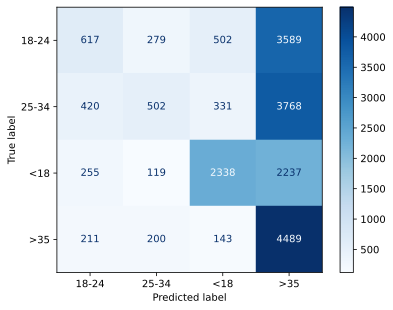

In [37]:
cm = confusion_matrix(y_test, y_pred, labels=gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
disp.display_labels = encoded_labels
disp.plot(cmap='Blues');

In [38]:
import joblib

joblib.dump(gs, 'age_punct.joblib')

['age_punct.joblib']

## LIWC features

In [8]:
from __future__ import division
from __future__ import print_function

import re

from codecs import open
from collections import Counter


class DictFeaturizer(object):
    def __init__(self, dictionary, relative=True):
        self.dict = {}
        self.rel = relative
        matcher = re.compile(r'([\*\+])')

        for key, words in dictionary.items():

            normal = {x for x in words if not matcher.findall(x)}
            regexstring = "|".join([matcher.sub(r'\\w\1', x)
                                    for x in words if x not in normal])

            if regexstring:
                wildcards = re.compile(regexstring)
            else:
                wildcards = None

            self.dict[key] = (normal, wildcards)

    def transform(self, tokens):
        # Make frequency dictionary of the text to diminish number
        # of runs in further for loop
        freq_dict = Counter(tokens)
        features = dict()

        for key, wordlists in self.dict.items():

            normal, wildcards = wordlists

            keys = set(freq_dict.keys())

            features[key] = sum([freq_dict[k] for k in normal & keys])
            if wildcards:
                features[key] += sum([freq_dict[k] for k in keys - normal
                                      if wildcards.match(k)])

        if self.rel:
            return {k: v / len(tokens) for k, v in features.items()}
        else:
            return features

    @staticmethod
    def load(path, relative=True):
        d = {}
        with open(path, "r", encoding='utf-8') as f:
            for line in f:
                line = line.lower().strip().split(",")
                key, words = line[0], set(line[1:])
                d[key] = words

        return DictFeaturizer(d, relative=relative)


In [9]:
init_df = pd.read_csv(f'{DATA_DIR}blog_authorship_tokenized_pos_punct_final.csv', encoding='utf-8')

In [10]:
cols_to_use = init_df.columns.difference(df_.columns)
cols_to_use

Index(['count_punct', 'gender', 'horoscope', 'job', 'pos', 'punct_dist',
       'total_punct'],
      dtype='object')

In [11]:
df_ = pd.merge(df_, init_df[cols_to_use], left_index=True, right_index=True)
df_.head()

,text,age_group,tokenized,count_punct,gender,horoscope,job,pos,punct_dist,total_punct
393442,"""No victor believes in chance."" Friedrich Niet...",0,""" no victor believes in chance . "" friedrich n...","{'!': 0, '""': 2, '#': 0, '$': 2, '%': 0, '&': ...",female,Capricorn,Publishing,PUNCT DET NOUN VERB ADP NOUN PUNCT PUNCT PROPN...,0.147059,25
182849,the talk of the town... The Passion of The Chr...,0,the talk of the town ... the passion of the ch...,"{'!': 0, '""': 0, '#': 0, '$': 0, '%': 0, '&': ...",male,Scorpio,Arts,DET NOUN ADP DET NOUN PUNCT DET NOUN ADP DET P...,0.048897,51
208908,"""Nothing Else Behaves Like Me"" From Thomas Oli...",0,""" nothing else behaves like me "" from thomas o...","{'!': 0, '""': 4, '#': 0, '$': 0, '%': 0, '&': ...",male,Gemini,Communications-Media,PUNCT PRON ADV PROPN ADP PRON PUNCT ADP PROPN ...,0.034205,17
311115,"Heehehe, don't worry, no one see this anyway. ...",0,"heehehe , do n't worry , no one see this anywa...","{'!': 3, '""': 2, '#': 0, '$': 0, '%': 0, '&': ...",male,Virgo,Communications-Media,PROPN PUNCT AUX PART VERB PUNCT DET NOUN VERB ...,0.059666,25
342064,Almost immediately after posting my comment ab...,0,almost immediately after posting my comment ab...,"{'!': 0, '""': 6, '#': 0, '$': 0, '%': 0, '&': ...",male,Libra,indUnk,ADV ADV ADP VERB PRON NOUN ADP PROPN PROPN CCO...,0.065350,43


In [12]:
df_.shape

(75000, 10)

In [14]:
liwc = DictFeaturizer.load(f"../../datasets/LIWC/LIWC_English.csv")

In [15]:
sample_df = df_.assign(liwc=df_['tokenized'].apply(liwc.transform))
sample_df

,text,age_group,tokenized,count_punct,gender,horoscope,job,pos,punct_dist,total_punct,liwc
393442,"""No victor believes in chance."" Friedrich Niet...",0,""" no victor believes in chance . "" friedrich n...","{'!': 0, '""': 2, '#': 0, '$': 2, '%': 0, '&': ...",female,Capricorn,Publishing,PUNCT DET NOUN VERB ADP NOUN PUNCT PUNCT PROPN...,0.147059,25,"{'funct': 0.08888888888888889, 'pronoun': 0.05..."
182849,the talk of the town... The Passion of The Chr...,0,the talk of the town ... the passion of the ch...,"{'!': 0, '""': 0, '#': 0, '$': 0, '%': 0, '&': ...",male,Scorpio,Arts,DET NOUN ADP DET NOUN PUNCT DET NOUN ADP DET P...,0.048897,51,"{'funct': 0.12168344007319305, 'pronoun': 0.06..."
208908,"""Nothing Else Behaves Like Me"" From Thomas Oli...",0,""" nothing else behaves like me "" from thomas o...","{'!': 0, '""': 4, '#': 0, '$': 0, '%': 0, '&': ...",male,Gemini,Communications-Media,PUNCT PRON ADV PROPN ADP PRON PUNCT ADP PROPN ...,0.034205,17,"{'funct': 0.12890625, 'pronoun': 0.072265625, ..."
311115,"Heehehe, don't worry, no one see this anyway. ...",0,"heehehe , do n't worry , no one see this anywa...","{'!': 3, '""': 2, '#': 0, '$': 0, '%': 0, '&': ...",male,Virgo,Communications-Media,PROPN PUNCT AUX PART VERB PUNCT DET NOUN VERB ...,0.059666,25,"{'funct': 0.12162162162162163, 'pronoun': 0.04..."
342064,Almost immediately after posting my comment ab...,0,almost immediately after posting my comment ab...,"{'!': 0, '""': 6, '#': 0, '$': 0, '%': 0, '&': ...",male,Libra,indUnk,ADV ADV ADP VERB PRON NOUN ADP PROPN PROPN CCO...,0.065350,43,"{'funct': 0.09393063583815028, 'pronoun': 0.04..."
...,...,...,...,...,...,...,...,...,...,...,...
46098,THE HUMAN SUNDIAL When I go to music festivals...,2,the human sundial when i go to music festivals...,"{'!': 0, '""': 0, '#': 0, '$': 0, '%': 0, '&': ...",female,Sagittarius,Internet,DET NOUN PROPN SCONJ PRON VERB ADP NOUN NOUN P...,0.016575,3,"{'funct': 0.11956521739130435, 'pronoun': 0.06..."
351169,I have a tooth ache. I hate it when a tooth hu...,2,i have a tooth ache . i hate it when a tooth h...,"{'!': 0, '""': 0, '#': 0, '$': 0, '%': 0, '&': ...",female,Aquarius,indUnk,PRON AUX DET NOUN NOUN PUNCT PRON VERB PRON SC...,0.036364,12,"{'funct': 0.13823529411764707, 'pronoun': 0.07..."
66494,"Just listened to Gore, Carter, and Clinton, an...",2,"just listened to gore , carter , and clinton ,...","{'!': 0, '""': 4, '#': 0, '$': 0, '%': 0, '&': ...",female,Aries,indUnk,ADV VERB ADP PROPN PUNCT PROPN PUNCT CCONJ PRO...,0.029374,23,"{'funct': 0.10421836228287841, 'pronoun': 0.05..."
580002,"Dr. Duf, Graphic novels? I got a stack you nee...",2,"dr. duf , graphic novels ? i got a stack you n...","{'!': 0, '""': 0, '#': 0, '$': 0, '%': 0, '&': ...",male,Aries,Fashion,PROPN PROPN PUNCT ADJ NOUN PUNCT PRON VERB DET...,0.051581,31,"{'funct': 0.10126582278481013, 'pronoun': 0.05..."


In [16]:
liwc_df = sample_df['liwc'].apply(pd.Series).fillna(0).add_prefix('liwc_')
sample_df = pd.concat([sample_df, liwc_df], axis=1).drop(['text', 'liwc'], axis=1)
sample_df.shape

(75000, 73)

In [17]:
sample_df['age_group'].value_counts()

0    25000
1    25000
2    25000
Name: age_group, dtype: int64

In [18]:
X = sample_df.drop('age_group', axis=1)
y = sample_df['age_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=97)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 72), (15000, 72), (60000,), (15000,))

In [19]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]


class RowIterator(TransformerMixin):
    """ Prepare Series for DictVectorizer """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        from ast import literal_eval
        return X.apply(literal_eval)

In [24]:
word_pipe = Pipeline([
    ('selector', ItemSelector(key='tokenized')),
    ('vect', TfidfVectorizer(analyzer='word'))
])

pos_pipe = Pipeline([
    ('selector', ItemSelector(key='pos')),
    ('vect', TfidfVectorizer(analyzer='word'))
])

num_cols = ['total_punct', 'punct_dist'] + [col for col in X.columns
                                            if col.startswith('liwc_')]

num_pipe = Pipeline([
    ('selector', ItemSelector(key=num_cols)),
])

punct_pipe = Pipeline([
    ('selector', ItemSelector(key='count_punct')),
    ('iter', RowIterator()),
    ('vect', DictVectorizer())
])

pipe = Pipeline([(
        'feats', 
        FeatureUnion([  
            ('word', word_pipe),
            ('pos', pos_pipe),
            ('num', num_pipe),
            ('punct', punct_pipe)
        ],
    )),
    ('clf', LinearSVC(C=0.1, random_state=97, class_weight='balanced')),
])

In [25]:
param_grid = {
    'feats__word__vect__ngram_range': [(1, 2), (1, 3)],
    'feats__pos__vect__ngram_range': [(1, 2), (1, 3)],
}

In [26]:
gs = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, refit=True, verbose=5)

gs.fit(X_train, y_train)
print(gs.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'feats__pos__vect__ngram_range': (1, 2), 'feats__word__vect__ngram_range': (1, 2)}


c:\Users\dimboump\workspace\onetab\venv\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [27]:
y_pred = gs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.41      0.47      4965
           1       0.67      0.80      0.73      5025
           2       0.61      0.65      0.63      5010

    accuracy                           0.62     15000
   macro avg       0.61      0.62      0.61     15000
weighted avg       0.61      0.62      0.61     15000



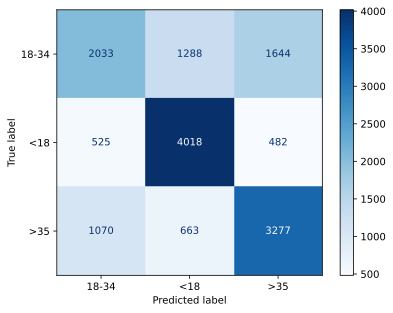

In [28]:
cm = confusion_matrix(y_test, y_pred, labels=gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
disp.display_labels = encoded_labels
disp.plot(cmap='Blues');

In [30]:
import joblib

joblib.dump(gs, 'age_liwc_3-class.joblib')

['age_liwc_3-class.joblib']